<a href="https://colab.research.google.com/github/Rachelslh/Softmax-classifier-from-scratch/blob/main/softmax_classifier_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
from tqdm.notebook import tqdm
import keras
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

In [89]:
class Layer:
  '''This is just a building block of our network'''
  def __init__(self):
    pass

  def forward(self, input):
    return input

  def backward(self, input, grad_output):
    """
    - Performs a backpropagation step through the layer, w.r.t input and learnable parameters
    - Updates the learnable parameters
    """
    return grad_output

In [90]:
class Dense(Layer):
  def __init__(self, input_units, output_units, learning_rate=0.1):
    """
    A dense layer is a layer which performs a learned affine transformation:
    f(x) = <W*x> + b
    """
    self.learning_rate = learning_rate
    # initialize weights with small random numbers. We use normal initialization i.e. weights are sampled from a normal distribution with mean=0 and STD=1
    self.weights = np.random.randn(input_units, output_units)*0.01
    self.biases = np.zeros(output_units)
  def forward(self, input):
    """
    Perform an affine transformation:
    f(x) = <W*x> + b
    input shape: [batch, input_units]
    output shape: [batch, output units]
    """
    return np.dot(input, self.weights) + self.biases

  def backward(self, input, grad_output):
    # compute d f / d x = d f / d dense * d dense / d x
    # where d dense/ d x = weights transposed
    grad_input = np.dot(grad_output, self.weights.T)
    # compute gradient w.r.t. weights and biases
    grad_weights = np.dot(input.T, grad_output)
    grad_biases = grad_output.sum(axis=0)
    assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

    # Here we perform a stochastic gradient descent step
    self.weights = self.weights - self.learning_rate * grad_weights
    self.biases = self.biases - self.learning_rate * grad_biases

    return grad_input

In [91]:
class ReLU(Layer):
  def __init__(self):
    """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
    pass

  def forward(self, input):
    """Apply elementwise ReLU to [batch, input_units] matrix"""
    return np.maximum(input, 0)

  def backward(self, input, grad_output):
    """Compute gradient of loss w.r.t. ReLU input"""
    relu_grad = input > 0 # 1 if input > 0 else 0
    return grad_output*relu_grad

In [92]:
class mnist_classifier:
  def __init__(self, input_shape):
    self.model = [
      Dense(input_shape,100),
      ReLU(),
      Dense(100,200),
      ReLU(),
      Dense(200,10)
    ]

  def forward(self, inputs):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer.
    """

    output_per_layer = [self.model[0].forward(inputs)]
    for idx in range(1, len(self.model)):
        output_per_layer.append(self.model[idx].forward(output_per_layer[idx - 1]))

    return output_per_layer

  def backward(self, input_per_layer, grad_output):
    layers_backward = self.model[::-1]
    for idx, layer in enumerate(layers_backward):
      grad_output = layer.backward(input_per_layer[::-1][idx+1], grad_output)

  def predict(self,X):
    """
    Compute network predictions.
    """
    logits = self.forward(X)[-1]
    return logits.argmax(axis=-1)

In [93]:
def softmax_crossentropy_with_logits(logits, groundtruth_labels):
  """Compute crossentropy from logits[batch,n_classes] and ids of correct labels"""
  logits_for_correct_labels = logits[np.arange(len(logits)),groundtruth_labels]
  xentropy = - logits_for_correct_labels + np.log(np.sum(np.exp(logits),axis=-1))

  return xentropy

def grad_softmax_crossentropy_with_logits(logits, groundtruth_labels):
  """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct labels"""
  ones_for_correct_labels = np.zeros_like(logits)
  ones_for_correct_labels[np.arange(len(logits)),groundtruth_labels] = 1

  softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
  return (- ones_for_correct_labels + softmax) / logits.shape[0]

In [94]:
def load_dataset(flatten=False):
  (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

  # normalize x
  X_train = X_train.astype(float) / 255.
  X_test = X_test.astype(float) / 255.

  # we reserve the last 10000 training examples for validation
  X_train, X_val = X_train[:-10000], X_train[-10000:]
  y_train, y_val = y_train[:-10000], y_train[-10000:]

  if flatten:
     X_train = X_train.reshape([X_train.shape[0], -1])
     X_val = X_val.reshape([X_val.shape[0], -1])
     X_test = X_test.reshape([X_test.shape[0], -1])

  return X_train, y_train, X_val, y_val, X_test, y_test

# Prep dataset into batches
def get_batches(inputs, targets, batchsize):
  for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
    excerpt = slice(start_idx, start_idx + batchsize)
    yield inputs[excerpt], targets[excerpt]

  0%|          | 0/1562 [00:00<?, ?it/s]

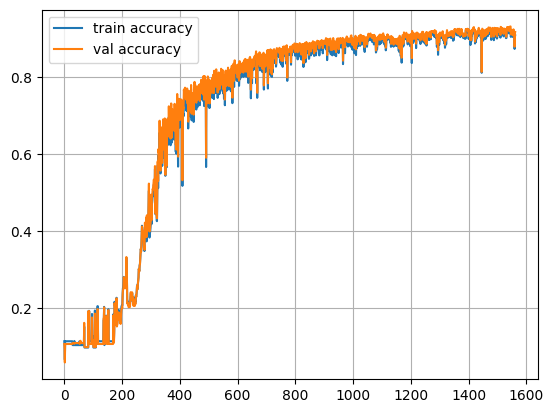

In [95]:
# Load the dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
# Prep the dataset into batches
#batches = get_batches(X_train, y_train, batchsize=32)

# Create model instance
model = mnist_classifier(X_train.shape[1])

train_log, val_log = [], []
for epoch in range(1):
  for (x_batch, y_batch) in get_batches(X_train, y_train, batchsize=32):

    # Get the layer activations
    output_per_layer = model.forward(x_batch)
    logits = output_per_layer[-1]
    input_per_layer = [x_batch]
    input_per_layer.extend(output_per_layer)

    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y_batch)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y_batch)

    model.backward(input_per_layer, loss_grad)
    train_log.append(np.mean(model.predict(X_train)==y_train))
    val_log.append(np.mean(model.predict(X_val)==y_val))

# Plot training and validation curves
plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

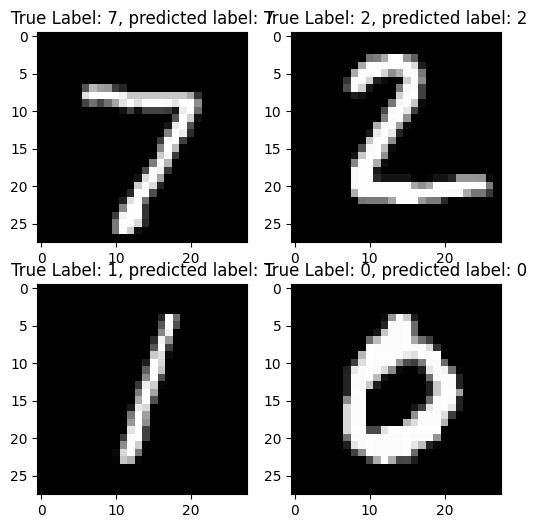

In [96]:
pred = model.predict(X_test[:4])

plt.figure(figsize=[6,6])
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.title(f"True Label: {y_test[i]}, predicted label: {pred[i]}")
  plt.imshow(X_test[i].reshape([28,28]),cmap='gray');